In [577]:
import pandas as pd
import numpy as np
import plotly.express as px
from scipy import stats
from plotly.subplots import make_subplots
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import plotly.graph_objects as go
colors = ['#082040', '#175073', '#3285A6', '#B8D0D9', '#6CC5D9']

In [578]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [579]:
import pickle

In [580]:
df = pd.read_csv(r'C:\Users\Ксения\Project\Magnet_Exchange_bias\data\Bias_data_2.csv')

In [581]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533 entries, 0 to 532
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         533 non-null    int64  
 1   volume             533 non-null    float64
 2   area               533 non-null    float64
 3   c1                 533 non-null    object 
 4   c2                 322 non-null    object 
 5   c3                 9 non-null      object 
 6   chemical_formula   533 non-null    object 
 7   crystal_structure  533 non-null    int64  
 8   z                  509 non-null    float64
 9   id                 533 non-null    int64  
 10  space_group_shell  533 non-null    int64  
 11  formula_combined   533 non-null    object 
 12  coer_oe            533 non-null    float64
 13  exc_bias_oe        533 non-null    float64
 14  fc_field_t         533 non-null    float64
 15  h_range_max_koe    533 non-null    float64
 16  y                  533 non

Пропуски в ожидемых местах среди целевых пременных пропусков нет

In [582]:
print(df.isna().sum(), df.shape, df.info(), sep=', ', end='\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533 entries, 0 to 532
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         533 non-null    int64  
 1   volume             533 non-null    float64
 2   area               533 non-null    float64
 3   c1                 533 non-null    object 
 4   c2                 322 non-null    object 
 5   c3                 9 non-null      object 
 6   chemical_formula   533 non-null    object 
 7   crystal_structure  533 non-null    int64  
 8   z                  509 non-null    float64
 9   id                 533 non-null    int64  
 10  space_group_shell  533 non-null    int64  
 11  formula_combined   533 non-null    object 
 12  coer_oe            533 non-null    float64
 13  exc_bias_oe        533 non-null    float64
 14  fc_field_t         533 non-null    float64
 15  h_range_max_koe    533 non-null    float64
 16  y                  533 non

In [583]:
df = df.drop(columns=['Unnamed: 0', 'c1', 'c2', 'c3']) # Колонку structure - нужно будет как-то закодировать 
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533 entries, 0 to 532
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   volume             533 non-null    float64
 1   area               533 non-null    float64
 2   chemical_formula   533 non-null    object 
 3   crystal_structure  533 non-null    int64  
 4   z                  509 non-null    float64
 5   id                 533 non-null    int64  
 6   space_group_shell  533 non-null    int64  
 7   formula_combined   533 non-null    object 
 8   coer_oe            533 non-null    float64
 9   exc_bias_oe        533 non-null    float64
 10  fc_field_t         533 non-null    float64
 11  h_range_max_koe    533 non-null    float64
 12  y                  533 non-null    float64
 13  mr (emu/g)         533 non-null    float64
 14  sat_em_g           533 non-null    float64
 15  shape              533 non-null    float64
 16  space_group_core   533 non

Столбец structure имеет в себе формулы с структурой формулы ядро/оболочка, поэтому она для модели не будет иметьсмысла, но для интерпритации важна, поэтому совместим её знчаения с колонкой id, которая тоже не несёт никакого знания о наносатицах напрямую. Создадим словарь, где каждый id - structure

In [584]:
print(len(df['id'].unique())) # Эта колнка состоит только из уникальных значений

533


In [585]:
dict_structure = {} # Словарь для кодирования
# Проходимся по каждой строке DataFrame и добавляем в словарь пару id-structure
for idx, row in df.iterrows():
    dict_structure[row['id']] = row['chemical_formula']
# Пример значения id, для которого мы хотим декодировать structure
id_value = 123

In [586]:
# Сохраняем словарь в файл с помощью pickle(пакет помогает сохранять данные и загружать обратно)
with open('dict_structure.pkl', 'wb') as f:
    pickle.dump(dict_structure, f)

In [587]:
# Проверка
decoded_structure = dict_structure[id_value]
print(decoded_structure)

['FeO', 'Fe3O4']


In [588]:
#del df['structure']
del df['chemical_formula']

In [589]:
print(df['crystal_structure'])

0      16
1       0
2       3
3       3
4       3
       ..
528    20
529    20
530    20
531    20
532    20
Name: crystal_structure, Length: 533, dtype: int64


In [590]:
print(df['crystal_structure'].unique()) # Разделиим и стандартизируемм значения, а потом перведём их в цифры и снова склеим

[16  0  3 19  7 24 13 21  9  2 25 22  1 10  5 23 14 15 12  4 11 20  6 18
 17  8]


In [591]:
dict_crystal_str = {
    'triclinic': 1, 'monoclinic': 2, 'orthorhombic': 3,
    'tetragonal': 4, 'trigonal': 5, 'hexagonal': 6,
    'cubic': 7, 'cube': 7
}

In [592]:
# Функция для кодирования списка значений в соответствии с словарем
def encode_crystal_list(crystal_list):
    return [dict_crystal_str[crystal] for crystal in crystal_list]

In [593]:
df = df.drop(columns=['crystal_structure', 'formula_combined', 'mass_ratio']) # object

In [594]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533 entries, 0 to 532
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   volume             533 non-null    float64
 1   area               533 non-null    float64
 2   z                  509 non-null    float64
 3   id                 533 non-null    int64  
 4   space_group_shell  533 non-null    int64  
 5   coer_oe            533 non-null    float64
 6   exc_bias_oe        533 non-null    float64
 7   fc_field_t         533 non-null    float64
 8   h_range_max_koe    533 non-null    float64
 9   y                  533 non-null    float64
 10  mr (emu/g)         533 non-null    float64
 11  sat_em_g           533 non-null    float64
 12  shape              533 non-null    float64
 13  space_group_core   533 non-null    float64
 14  temperature_k      533 non-null    float64
 15  ver_shift_emu_g    533 non-null    float64
 16  x                  533 non

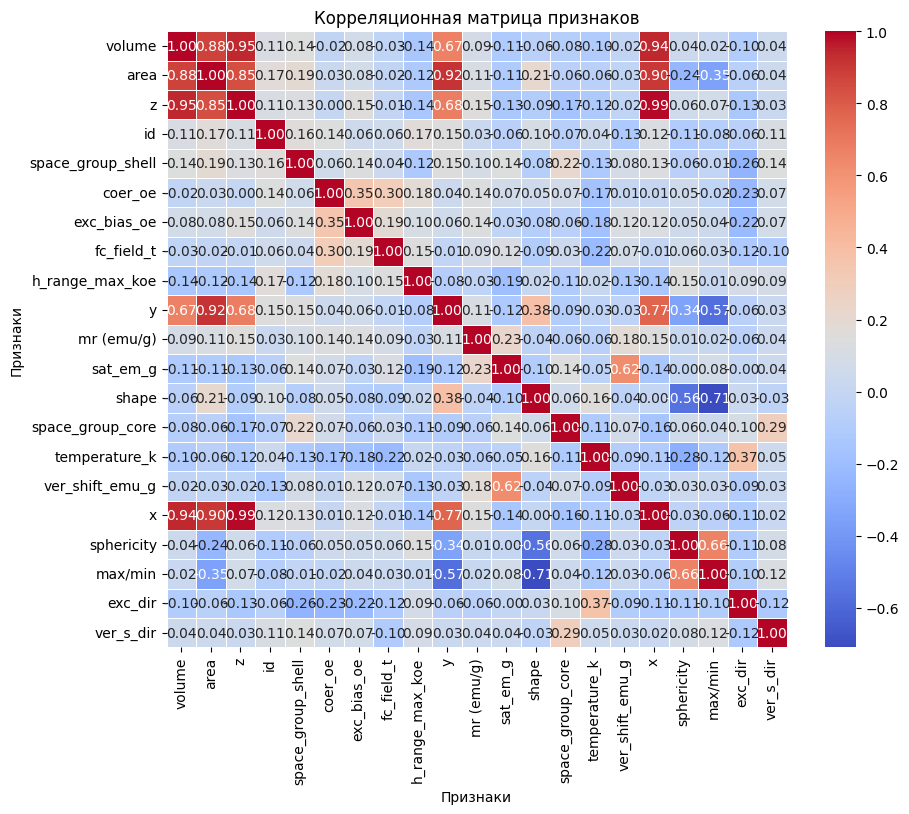

In [595]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.7)
plt.title('Корреляционная матрица признаков')
plt.xlabel('Признаки')
plt.ylabel('Признаки')
plt.show()

In [596]:
df['area/volume'] = df['area'] / df['volume']

In [597]:
df = df.drop(columns=['x', 'y', 'z', 'area', 'volume']) # Корреляции

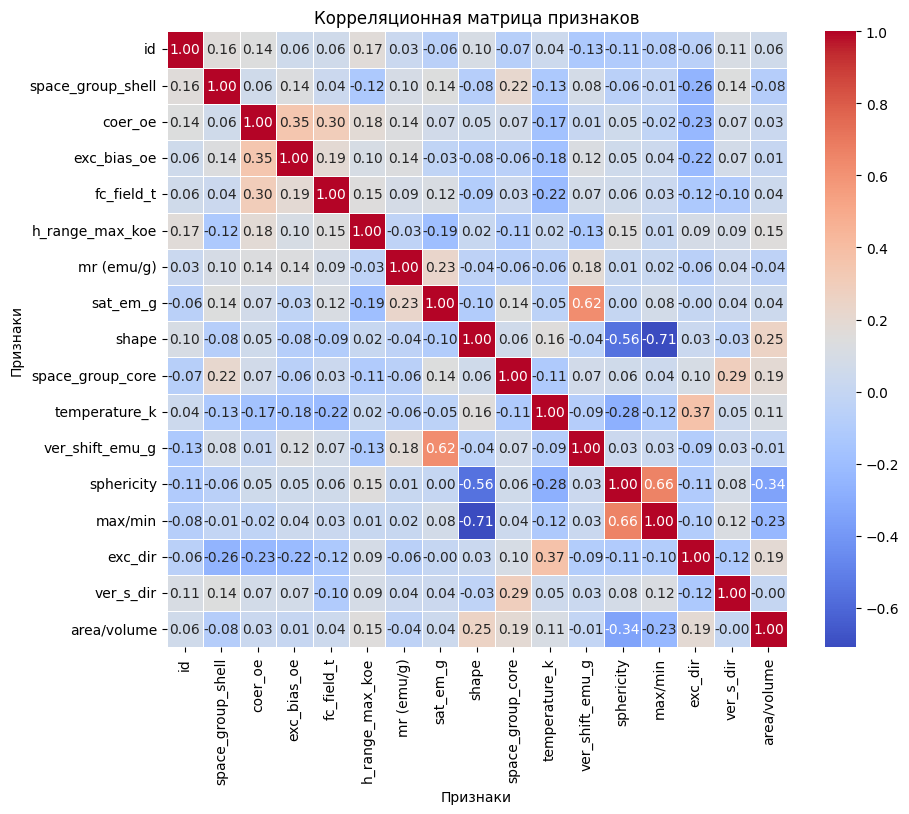

In [598]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.7)
plt.title('Корреляционная матрица признаков')
plt.xlabel('Признаки')
plt.ylabel('Признаки')
plt.show()

In [599]:
df.to_csv(r'C:\Users\Ксения\Project\Magnet_Exchange_bias\data\B2.csv')

In [600]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display

In [601]:
#Построим график распределения целевой переменной
fig = make_subplots(rows=1, cols=2, subplot_titles=['Histogram for exchange bias', 'Violin Plot for exchange bias'])

# Histogram
hist_fig = px.histogram(df, x="exc_bias_oe", nbins = 60,
                 color_discrete_sequence = colors,
                 opacity = 0.7)

fig.add_trace(hist_fig['data'][0], row=1, col=1) # Adding a graph indicating the location

# Violin plot
violin_fig = px.violin(df, y="exc_bias_oe", color_discrete_sequence = colors, box = True)
fig.add_trace(violin_fig['data'][0], row=1, col=2) # Adding a graph indicating the location

# Setting up the layout
fig.update_layout(showlegend=False, title_text="Pic for exchange bias")

# Graph display
display(fig)

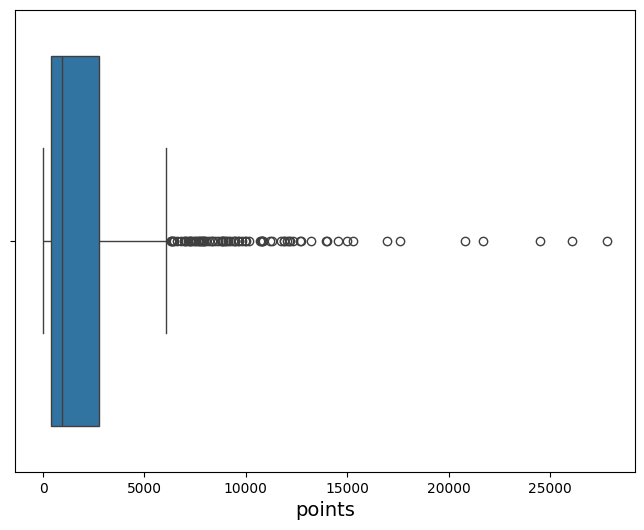

In [602]:
plt.figure(figsize=(8, 6)) # Создание ящика с усами для столбца 'exc_bias_oe'
sns.boxplot(x=df['coer_oe'])
plt.xlabel('points', fontsize=14) # Добавление названия оси x
plt.show()

In [603]:
#Ещё посмотрим с помощью интерквартального расстояния, так будет понятней, значения за первым и 3 квартилям будут выбросами
def detect_outliers_iqr(data, threshold=1.5):
    """
    Detect outliers using the Interquartile Range (IQR) method.

    Parameters:
        data (array-like): Input data.
        threshold (float): Multiplier for the IQR to determine the outlier cutoff.

    Returns:
        outliers (array-like): Array containing the indices of outlier data points.
    """
    quartile_1, quartile_3 = np.percentile(data, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (threshold * iqr)
    upper_bound = quartile_3 + (threshold * iqr)
    outliers = np.where((data < lower_bound) | (data > upper_bound))[0]
    return outliers

# Example usage:
outliers = detect_outliers_iqr(df['exc_bias_oe'])
print("Индексы выбросов:", outliers)
print("Значения выбросов:", [df['exc_bias_oe'][i] for i in outliers])

Индексы выбросов: [ 16  54  63 112 113 119 121 123 124 136 137 140 152 153 157 171 189 190
 191 192 193 194 208 209 215 234 267 272 390 391 398 399 400 401 402 403
 433 448 488 489 490 491 492 504 506 521 522 532]
Значения выбросов: [2157.0, 7238.0, 2878.5, 2762.0, 2250.0, 2188.0, 3500.0, 22459.0, 18003.0, 2275.0, 2120.0, 1972.0, 2800.0, 2600.0, 3650.0, 2750.0, 3430.0, 4020.0, 5100.0, 3773.58, 5283.0, 5283.0, 2560.0, 2120.0, 3600.0, 2173.9, 2068.9, 2847.4576, 4408.0, 6350.0, 2083.0, 5121.9692, 10414.0, 8514.585999999998, 6372.383, 5325.26, 2755.17, 2000.0, 5753.62, 8310.58, 9418.761, 9573.644, 8410.919999999998, 5653.0, 2920.0, 1895.0, 1907.9, 1976.41]


In [604]:
# Detect outliers
outliers = detect_outliers_iqr(df['exc_bias_oe'])

# Получение значений выбросов
outlier_values = df.loc[outliers, 'exc_bias_oe']

# Scatter plot
fig = go.Figure()

# Plot all data points
fig.add_trace(go.Scatter(x=np.arange(len(df['exc_bias_oe'])), y=df['exc_bias_oe'], mode='markers', name='Data Points', marker=dict(color=colors[2])))

# Highlight outliers
fig.add_trace(go.Scatter(x=outliers, y=outlier_values, mode='markers', marker=dict(color=colors[0]), name='Outliers'))

# Add layout
fig.update_layout(title='Outlier Detection Using IQR Method',
                  xaxis_title='Index',
                  yaxis_title='Value')

# Show plot
display(fig)

In [605]:
out_data = df.drop(outliers)
print(out_data.head())

   id  space_group_shell   coer_oe  exc_bias_oe  fc_field_t  h_range_max_koe  \
0   1                227  27800.00      1132.00         5.0             50.0   
1   2                227   7800.00       406.00         5.0             50.0   
2   3                  0     24.80        51.34         0.0             10.0   
3   4                  0     90.20       108.18         0.0             10.0   
4   5                  0     40.07         8.92         0.0             10.0   

   mr (emu/g)  sat_em_g  shape  space_group_core  temperature_k  \
0    13.76705   52.1524    1.0             186.0            5.0   
1    43.26420   83.1400    1.0             225.0            5.0   
2     0.00780    2.2900    1.0             227.0          300.0   
3     0.02180    2.4300    1.0             227.0          300.0   
4     0.34980   16.1500    1.0             227.0          300.0   

   ver_shift_emu_g  sphericity  max/min  exc_dir  ver_s_dir  area/volume  
0              0.0         1.0        1  

In [606]:
df = out_data
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 485 entries, 0 to 531
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 485 non-null    int64  
 1   space_group_shell  485 non-null    int64  
 2   coer_oe            485 non-null    float64
 3   exc_bias_oe        485 non-null    float64
 4   fc_field_t         485 non-null    float64
 5   h_range_max_koe    485 non-null    float64
 6   mr (emu/g)         485 non-null    float64
 7   sat_em_g           485 non-null    float64
 8   shape              485 non-null    float64
 9   space_group_core   485 non-null    float64
 10  temperature_k      485 non-null    float64
 11  ver_shift_emu_g    485 non-null    float64
 12  sphericity         485 non-null    float64
 13  max/min            485 non-null    int64  
 14  exc_dir            485 non-null    int64  
 15  ver_s_dir          485 non-null    int64  
 16  area/volume        485 non

In [607]:
#Построим график распределения целевой переменной
fig = make_subplots(rows=1, cols=2, subplot_titles=['Histogram for exchange bias', 'Violin Plot for exchange bias'])

# Histogram
hist_fig = px.histogram(df, x="exc_bias_oe", nbins = 60,
                 color_discrete_sequence = colors,
                 opacity = 0.7)

fig.add_trace(hist_fig['data'][0], row=1, col=1) # Adding a graph indicating the location

# Violin plot
violin_fig = px.violin(df, y="exc_bias_oe", color_discrete_sequence = colors, box = True)
fig.add_trace(violin_fig['data'][0], row=1, col=2) # Adding a graph indicating the location

# Setting up the layout
fig.update_layout(showlegend=False, title_text="Pic for exchange bias after outliers")

# Graph display
print(display(fig))

None


In [608]:
exc_bias_min = df['exc_bias_oe'].min()
exc_bias_max = df['exc_bias_oe'].max()

print(f"Диапазон значений переменной 'exc_bias_oe': от {exc_bias_min} до {exc_bias_max}")

Диапазон значений переменной 'exc_bias_oe': от 0.0 до 1879.0


In [609]:
df['exc_bias_oe'] = np.log10(df['exc_bias_oe'])

c:\Users\Ксения\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning:

divide by zero encountered in log10



In [610]:
#Построим график распределения целевой переменной
fig = make_subplots(rows=1, cols=2, subplot_titles=['Histogram for exchange bias', 'Violin Plot for exchange bias'])

# Histogram
hist_fig = px.histogram(df, x="exc_bias_oe", nbins = 60,
                 color_discrete_sequence = colors,
                 opacity = 0.7)

fig.add_trace(hist_fig['data'][0], row=1, col=1) # Adding a graph indicating the location

# Violin plot
violin_fig = px.violin(df, y="exc_bias_oe", color_discrete_sequence = colors, box = True)
fig.add_trace(violin_fig['data'][0], row=1, col=2) # Adding a graph indicating the location

# Setting up the layout
fig.update_layout(showlegend=False, title_text="Pic for exchange bias after outliers")

# Graph display
print(display(fig))

None


In [611]:
exc_bias_min = df['exc_bias_oe'].min()
exc_bias_max = df['exc_bias_oe'].max()

print(f"Диапазон значений переменной 'exc_bias_oe': от {exc_bias_min} до {exc_bias_max}")

Диапазон значений переменной 'exc_bias_oe': от -inf до 3.2739267801005254


In [612]:
exc_bias_oe = df['exc_bias_oe']
id = df['id']

In [613]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 485 entries, 0 to 531
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 485 non-null    int64  
 1   space_group_shell  485 non-null    int64  
 2   coer_oe            485 non-null    float64
 3   exc_bias_oe        485 non-null    float64
 4   fc_field_t         485 non-null    float64
 5   h_range_max_koe    485 non-null    float64
 6   mr (emu/g)         485 non-null    float64
 7   sat_em_g           485 non-null    float64
 8   shape              485 non-null    float64
 9   space_group_core   485 non-null    float64
 10  temperature_k      485 non-null    float64
 11  ver_shift_emu_g    485 non-null    float64
 12  sphericity         485 non-null    float64
 13  max/min            485 non-null    int64  
 14  exc_dir            485 non-null    int64  
 15  ver_s_dir          485 non-null    int64  
 16  area/volume        485 non

In [614]:
# Проверить наличие значений "inf" в DataFrame
has_inf = df.isin([np.inf, -np.inf]).any().any()

if has_inf:
    print("DataFrame содержит значения 'inf'")
else:
    print("DataFrame не содержит значения 'inf'")

DataFrame содержит значения 'inf'


In [615]:
# Найти количество значений "inf" в каждом столбце DataFrame
inf_count_per_column = df.isin([np.inf, -np.inf]).sum()

# Вывести количество значений "inf" в каждом столбце
print("Количество значений 'inf' в каждом столбце:")
print(inf_count_per_column)

Количество значений 'inf' в каждом столбце:
id                    0
space_group_shell     0
coer_oe               0
exc_bias_oe          99
fc_field_t            0
h_range_max_koe       0
mr (emu/g)            0
sat_em_g              0
shape                 0
space_group_core      0
temperature_k         0
ver_shift_emu_g       0
sphericity            0
max/min               0
exc_dir               0
ver_s_dir             0
area/volume           0
dtype: int64


In [616]:
# Найти среднее значение столбца 'exc_bias_oe', исключив значения '-inf'
mean_exc_bias_oe = df.loc[df['exc_bias_oe'] != -np.inf, 'exc_bias_oe'].mean()

# Заменить значения '-inf' в столбце 'exc_bias_oe' на среднее значение, только если значение не равно '-inf'
df.loc[df['exc_bias_oe'] == -np.inf, 'exc_bias_oe'] = mean_exc_bias_oe

In [617]:
print(mean_exc_bias_oe)

2.12899804089295


In [618]:
# Найти количество значений "inf" в каждом столбце DataFrame
inf_count_per_column = df.isin([np.inf, -np.inf]).sum()

# Вывести количество значений "inf" в каждом столбце
print("Количество значений 'inf' в каждом столбце:")
print(inf_count_per_column)

Количество значений 'inf' в каждом столбце:
id                   0
space_group_shell    0
coer_oe              0
exc_bias_oe          0
fc_field_t           0
h_range_max_koe      0
mr (emu/g)           0
sat_em_g             0
shape                0
space_group_core     0
temperature_k        0
ver_shift_emu_g      0
sphericity           0
max/min              0
exc_dir              0
ver_s_dir            0
area/volume          0
dtype: int64


In [619]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 485 entries, 0 to 531
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 485 non-null    int64  
 1   space_group_shell  485 non-null    int64  
 2   coer_oe            485 non-null    float64
 3   exc_bias_oe        485 non-null    float64
 4   fc_field_t         485 non-null    float64
 5   h_range_max_koe    485 non-null    float64
 6   mr (emu/g)         485 non-null    float64
 7   sat_em_g           485 non-null    float64
 8   shape              485 non-null    float64
 9   space_group_core   485 non-null    float64
 10  temperature_k      485 non-null    float64
 11  ver_shift_emu_g    485 non-null    float64
 12  sphericity         485 non-null    float64
 13  max/min            485 non-null    int64  
 14  exc_dir            485 non-null    int64  
 15  ver_s_dir          485 non-null    int64  
 16  area/volume        485 non

In [620]:
scaler = MinMaxScaler()
df_enc_scaled = scaler.fit_transform(df)
df_enc_scaled = pd.DataFrame(df_enc_scaled, columns=df.columns)
df_enc_scaled['exc_bias_oe'] = exc_bias_oe
df = df_enc_scaled
print(df)

           id  space_group_shell   coer_oe  exc_bias_oe  fc_field_t  \
0    0.000000           0.991266  1.000000     3.053846    0.071429   
1    0.001883           0.991266  0.280576     2.608526    0.071429   
2    0.003766           0.000000  0.000892     1.710456    0.000000   
3    0.005650           0.000000  0.003245     2.034147    0.000000   
4    0.007533           0.000000  0.001441     0.950365    0.000000   
..        ...                ...       ...          ...         ...   
480  0.992467           0.982533  0.038948         -inf    0.014286   
481  0.994350           0.982533  0.041184         -inf    0.028571   
482  0.996234           0.982533  0.045324     1.704879    0.042857   
483  0.998117           0.982533  0.047572     2.403782    0.057143   
484  1.000000           0.982533  0.052252     2.151590    0.071429   

     h_range_max_koe  mr (emu/g)  sat_em_g  shape  space_group_core  \
0           0.555061    0.055521  0.135607    0.0          0.811404   
1    

In [621]:
missing_values = df.isnull().sum()
mean_exc_bias_oe = df['exc_bias_oe'].mean()
df['exc_bias_oe'].fillna(mean_exc_bias_oe, inplace=True)
print(missing_values)

id                    0
space_group_shell     0
coer_oe               0
exc_bias_oe          38
fc_field_t            0
h_range_max_koe       0
mr (emu/g)            0
sat_em_g              0
shape                 0
space_group_core      0
temperature_k         0
ver_shift_emu_g       0
sphericity            0
max/min               0
exc_dir               0
ver_s_dir             0
area/volume           0
dtype: int64


In [622]:
df.to_csv(r'C:\Users\Ксения\Project\Magnet_Exchange_bias\data\Bias_data_NEW.csv')

In [624]:
#Построим график распределения целевой переменной
fig = make_subplots(rows=1, cols=2, subplot_titles=['Histogram for exchange bias', 'Violin Plot for exchange bias'])

# Histogram
hist_fig = px.histogram(df, x="smoothed_exc_bias_oe", nbins = 60,
                 color_discrete_sequence = colors,
                 opacity = 0.7)

fig.add_trace(hist_fig['data'][0], row=1, col=1) # Adding a graph indicating the location

# Violin plot
violin_fig = px.violin(df, y="smoothed_exc_bias_oe", color_discrete_sequence = colors, box = True)
fig.add_trace(violin_fig['data'][0], row=1, col=2) # Adding a graph indicating the location

# Setting up the layout
fig.update_layout(showlegend=False, title_text="Pic for exchange bias after outliers")

# Graph display
print(display(fig))

None


In [625]:
from sklearn.impute import KNNImputer

# Создание экземпляра KNNImputer
imputer = KNNImputer()

# Применение импутации к столбцу 'exc_bias_oe'
df['exc_bias_oe'] = imputer.fit_transform(df[['exc_bias_oe']])
df['smoothed_exc_bias_oe'] = imputer.fit_transform(df[['smoothed_exc_bias_oe']])

ValueError: Input X contains infinity or a value too large for dtype('float64').

In [ ]:
missing_values = df.isnull().sum()
print(missing_values)

id                        0
space_group_shell         0
coer_oe                   0
exc_bias_oe               0
fc_field_t                0
h_range_max_koe           0
mr (emu/g)                0
sat_em_g                  0
shape                     0
space_group_core          0
temperature_k             0
ver_shift_emu_g           0
sphericity                0
max/min                   0
exc_dir                   0
ver_s_dir                 0
area/volume               0
smoothed_exc_bias_oe    268
dtype: int64


In [ ]:
df = df.drop(columns=['id']) # Просто порядковый номер моих наночастиц, чтобы отличать их друг от друга

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485 entries, 0 to 484
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   space_group_shell     485 non-null    float64
 1   coer_oe               485 non-null    float64
 2   exc_bias_oe           485 non-null    float64
 3   fc_field_t            485 non-null    float64
 4   h_range_max_koe       485 non-null    float64
 5   mr (emu/g)            485 non-null    float64
 6   sat_em_g              485 non-null    float64
 7   shape                 485 non-null    float64
 8   space_group_core      485 non-null    float64
 9   temperature_k         485 non-null    float64
 10  ver_shift_emu_g       485 non-null    float64
 11  sphericity            485 non-null    float64
 12  max/min               485 non-null    float64
 13  exc_dir               485 non-null    float64
 14  ver_s_dir             485 non-null    float64
 15  area/volume           4

In [ ]:
df.to_csv(r'C:\Users\Ксения\Project\Magnet_Exchange_bias\data\Bias_data_3.csv')